<a href="https://colab.research.google.com/github/JPVillamizarCastillo/TRAINING/blob/main/Ejercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio de clustering

 El objetivo es tratar de identificar grupos de pasajeros que tengan características similares con el fin de dirigirse a diferentes segmentos para distintos tipos de ofertas de millas.

---


## Descripción de los datos

El archivo EastWestAirlines contiene la información del programa de viajero frecuente de los pasajeros de una aerolínea. Para cada pasajero los datos incluyen información del historial de millas

Para cada pasajero, los datos incluyen información sobre su historial de millas y sobre las diferentes formas en que acumularon o gastaron millas en el último año. El objetivo es tratar de identificar grupos de pasajeros que tengan características similares con el fin de dirigirse a diferentes segmentos para distintos tipos de ofertas de millas.

* ID#: Unique ID

* Balance: Number of miles eligible for award travel

* Qual_mile: Number of miles counted as qualifying for Topflight status

* cc1_miles: Number of miles earned with freq. flyer credit card in the past 12 months.

* cc2_miles: Number of miles earned with Rewards credit card in the past 12 months.

* cc3_miles: Number of miles earned with Small Business credit card in the past 12 months.

  * 1 = under 5,000

  * 2 = 5,000 - 10,000

  * 3 = 10,001 - 25,000

  * 4 = 25,001 - 50,000

  * 5 = over 50,000

* Bonus_miles: Number of miles earned from non-flight bonus transactions in the past 12 months

* Bonus_trans: Number of non-flight bonus transactions in the past 12 months

* Flight_miles_12mo: Number of flight miles in the past 12 months

* Flight_trans_12: Number of flight transactions in the past 12 months

* Days_since_enrolled: Number of days since enrolled in flier program

* Award?--whether that person had award flight (free flight) or not

## Key Intuition questions

* "Are we trying to identify high-value flyers, frequent travelers, or credit card users?"
* "Which variables will most strongly differentiate these groups?"

# Preparación del ambiente

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
path= '/content/drive/MyDrive/ESTUDIO/UNI/OCTAVO SEMESTRE/Aprendizaje no supervisado/BASES DE DATOS/EastWestAirlines.csv'
df= pd.read_csv(path, sep=",")

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


# Variables selection

* Balance
* Flight_miles_12mo
* cc1_miles
* Award

In [ ]:
df.columns # Para conocer el nombre de las columnas

Index(['ID', 'Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12',
       'Days_since_enroll', 'Award'],
      dtype='object')

In [ ]:
df_k=df[["Balance", "Flight_miles_12mo", "cc1_miles", "Award"]]
df_k.head()

,Balance,Flight_miles_12mo,cc1_miles,Award
0,28143,0,1,0
1,19244,0,1,0
2,41354,0,1,0
3,14776,0,1,0
4,97752,2077,4,1


**Correlation**

it is important to have low-moderate correlation between the variables, this ensure that the variables are capturing distinct dimensions of customer behavior. this permit that K-means create more meaningful and well-separted clusters.

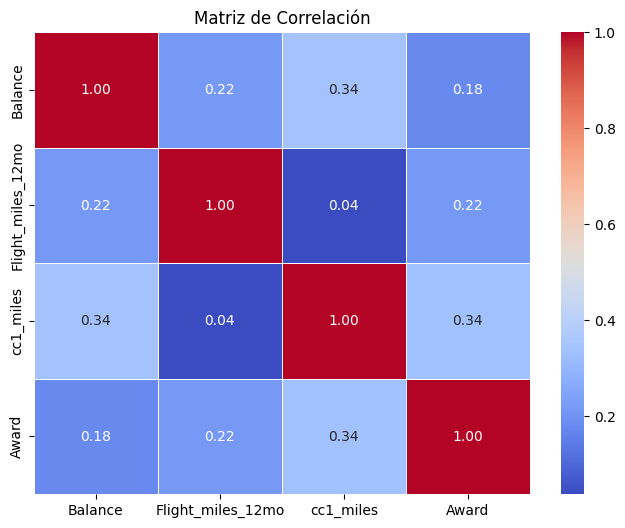

In [ ]:
corr_matrix = df_k.corr()
plt.figure(figsize=(8,6))  # Ajusta el tamaño del gráfico
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

An option for letter:
Combine Variables (Feature Engineering):
If the correlated variables represent related information, you might be able to combine them into a single new variable. For example, if "Flight_miles_12mo" and "Flight_trans_12" are highly correlated, you could create a new variable that represents "average miles per flight."

In [ ]:
df_k.describe()

,Balance,Flight_miles_12mo,cc1_miles,Award
count,3.999000e+03,3999.000000,3999.000000,3999.000000
mean,7.360133e+04,460.055764,2.059515,0.370343
std,1.007757e+05,1400.209171,1.376919,0.482957
min,0.000000e+00,0.000000,1.000000,0.000000
25%,1.852750e+04,0.000000,1.000000,0.000000
50%,4.309700e+04,0.000000,1.000000,0.000000
75%,9.240400e+04,311.000000,3.000000,1.000000
max,1.704838e+06,30817.000000,5.000000,1.000000


## Outliers detection

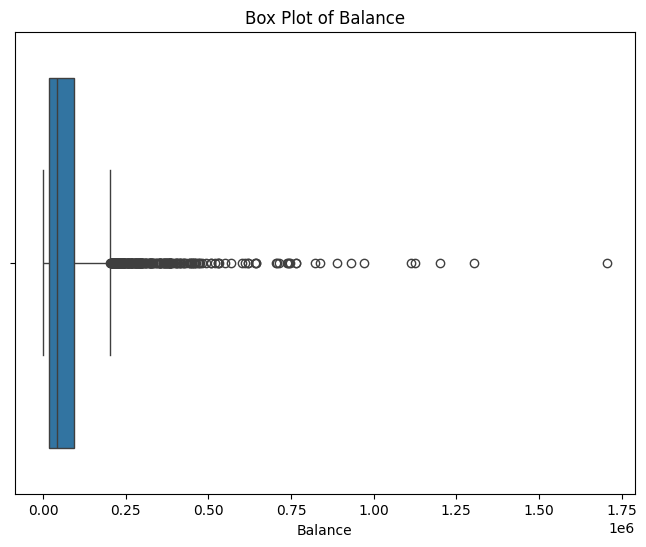

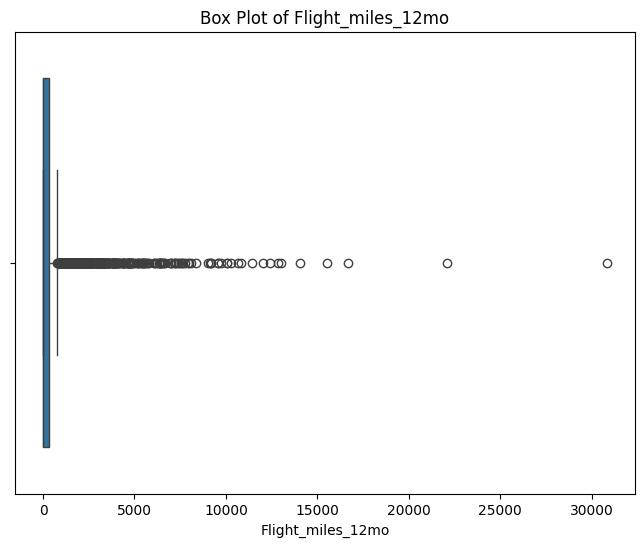

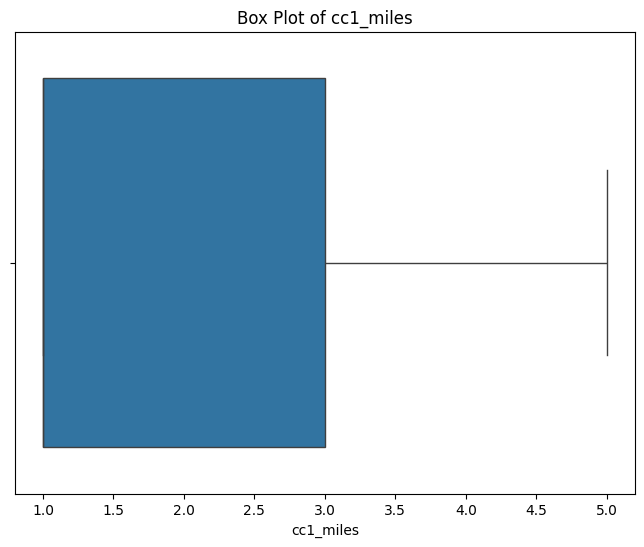

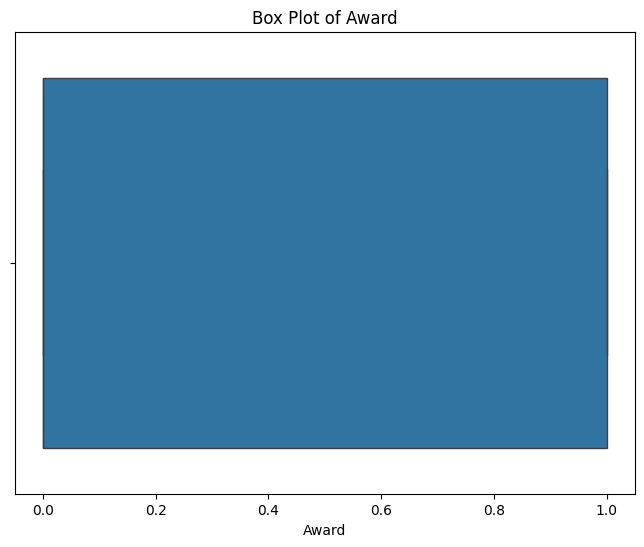

In [ ]:
def create_multiple_boxplots(df, variable_list):
    """Creates separate box plots for each variable in the list."""
    for variable in variable_list:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=df[variable])
        plt.title(f'Box Plot of {variable}')
        plt.show()

variables_to_plot = ["Balance", "Flight_miles_12mo", "cc1_miles", "Award"]
create_multiple_boxplots(df, variables_to_plot)

Debemos primero elininar outliers y luego estandarizar variables si es necesario

In [ ]:
#Definimos una función que identifique los outliers

def outliers_iqr(variable):
  """
  Con esta función obtenemos los valores atípicos con el método de IQR
  """
  Q1 = variable.quantile(0.25) # calculamos el Q1
  Q3 = variable.quantile(0.75) # Calculamos el Q3
  IQR = Q3 - Q1 # Calculamos el rango inter quantil
  # Obtenemos los límites
  lower_bound = Q1 - 1.5 * IQR  # límite inferior
  upper_bound = Q3 + 1.5 * IQR # Límite superior
  outliers = np.where( (variable < lower_bound) | (variable > upper_bound), 1,0 )  # 1 atípico
  return outliers # Retornamos la etiqueta de atípico

In [ ]:
#Filtering the outliers for each variable
# The outliers_iqr function returns an array of 0s and 1s
# We want to filter the DataFrame based on where this array is 1 (indicating an outlier)

# For Balance:
outlier_indices_balance = outliers_iqr(df_k["Balance"])
out_balance = df_k[outlier_indices_balance == 1]  # Subset df_k based on outlier flags

# For Flight_miles_12mo:
outlier_indices_flight = outliers_iqr(df_k["Flight_miles_12mo"])
out_flight = df_k[outlier_indices_flight == 1]

# For cc1_miles:
outlier_indices_cc1 = outliers_iqr(df_k["cc1_miles"])
out_cc1 = df_k[outlier_indices_cc1 == 1]

out_balance.head()

,Balance,Flight_miles_12mo,cc1_miles,Award
8,443003,3850,3,1
24,205651,700,1,0
32,276571,0,4,0
43,619393,0,3,1
45,288865,2000,1,1


Observation: We had detected a lot outliers in our variables "Balance" & "Flight_miles". however, according to the context this variables are valid data, so we decided to maintain them.

## Standarization

According to the scales of the variables, we need to apply standarization.

Vastly Different Scales:
* Balance: Ranges from 0 to 1,704,838.
* Flight_miles_12mo: Ranges from 0 to 30,817.
* cc1_miles: Ranges from 1 to 5.
* Award: Ranges from 0 to 1.

In [ ]:
scaler=StandardScaler()
scaled_features=scaler.fit_transform(df_k)
scaled_features

array([[-4.51140783e-01, -3.28603258e-01, -7.69578406e-01,
        -7.66919299e-01],
       [-5.39456874e-01, -3.28603258e-01, -7.69578406e-01,
        -7.66919299e-01],
       [-3.20031232e-01, -3.28603258e-01, -7.69578406e-01,
        -7.66919299e-01],
       ...,
       [-4.29480975e-05, -3.28603258e-01,  6.83121167e-01,
         1.30391816e+00],
       [-1.85606976e-01,  2.85309024e-02, -7.69578406e-01,
        -7.66919299e-01],
       [-7.00507951e-01, -3.28603258e-01, -7.69578406e-01,
        -7.66919299e-01]])

In [ ]:
est=pd.DataFrame(scaled_features, columns=df_k.columns)
est

,Balance,Flight_miles_12mo,cc1_miles,Award
0,-0.451141,-0.328603,-0.769578,-0.766919
1,-0.539457,-0.328603,-0.769578,-0.766919
2,-0.320031,-0.328603,-0.769578,-0.766919
3,-0.583799,-0.328603,-0.769578,-0.766919
4,0.239678,1.154932,1.409471,1.303918
...,...,...,...,...
3994,-0.547079,-0.185750,-0.769578,1.303918
3995,-0.091465,-0.328603,-0.769578,1.303918
3996,-0.000043,-0.328603,0.683121,1.303918
3997,-0.185607,0.028531,-0.769578,-0.766919


## K-MEANS

Using the elbow method we can know the number of clusters that we need.

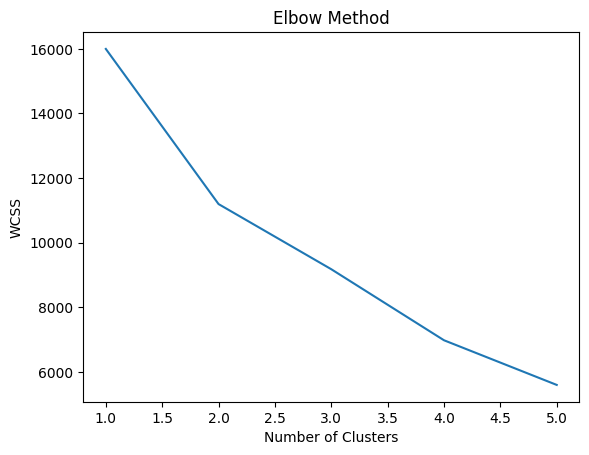

In [ ]:
wcss = [] # crear una lista para almacenar los valores de WCSS

# Calcular el WCSS para diferentes valores de k
for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Gráfico del codo
plt.plot(range(1, 6), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Observation: The best option is use 2 clusteers in our model.

In [ ]:
kmeans = KMeans(
  init="random", # Este parámetro determina donde se ubican los centroides inicialmente
  n_clusters=2, # Corresponde al número de clusters que se van a crear
  n_init=10, # El número de veces que se iniciarán los centroides para seleccionar los mejores, según la inercia
  max_iter=300, # Número máximo de iteraciones para encontrar los clusters optimos
  random_state=42 # Este valor asegura que los resultados son reproducibles
  )

In [ ]:
kmeans.fit(scaled_features) #Ajustamos el modelo

KMeans(init='random', n_clusters=2, n_init=10, random_state=42)

In [ ]:
kmeans.cluster_centers_ # Muestra los centroides de los clusters

array([[ 0.28599626,  0.30651188,  0.45922325,  1.25744392],
       [-0.17443009, -0.18694263, -0.28008181, -0.7669193 ]])

In [ ]:
#Retornamos los centroides a su escala original
standardized_centroids = kmeans.cluster_centers_

original_centroids = scaler.inverse_transform(standardized_centroids)
original_centroids

array([[ 1.02419187e+05,  8.89182838e+02,  2.69174917e+00,
         9.77557756e-01],
       [ 5.60252174e+04,  1.98329710e+02,  1.67391304e+00,
        -7.16093851e-15]])

Observamos en que cluster quedo cada uno de los registros

In [ ]:
labels=kmeans.predict(scaled_features)
df['cluster']=labels
df

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,cluster
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,4017,18476,0,1,1,1,8525,4,200,1,1403,1,0
3995,4018,64385,0,1,1,1,981,5,0,0,1395,1,0
3996,4019,73597,0,3,1,1,25447,8,0,0,1402,1,0
3997,4020,54899,0,1,1,1,500,1,500,1,1401,0,1


## Caracterización de los clusters

In [ ]:
def dividir_por_cluster(df_original, etiquetas_cluster):
    """
    Divide un dataframe en dataframes separados por cluster.

    Args:
        df_original (pd.DataFrame): El dataframe original.
        etiquetas_cluster (pd.Series o np.array): Las etiquetas de cluster asignadas a cada registro.

    Returns:
        dict: Un diccionario donde las claves son los números de cluster y los valores son los dataframes correspondientes.
    """

    # Asegurarse de que las etiquetas de cluster sean una Serie de pandas
    etiquetas_cluster = pd.Series(etiquetas_cluster)

    # Crear una copia del dataframe original
    df_copia = df_original.copy()

    # Agregar las etiquetas de cluster como una nueva columna al dataframe copiado
    df_copia['Cluster'] = etiquetas_cluster

    # Obtener los números de cluster únicos
    clusters_unicos = etiquetas_cluster.unique()

    # Crear un diccionario para almacenar los dataframes por cluster
    dataframes_cluster = {}

    # Iterar sobre los clusters únicos y crear dataframes separados
    for cluster in clusters_unicos:
        dataframes_cluster[cluster] = df_copia[df_copia['Cluster'] == cluster].drop('Cluster', axis=1)

    return dataframes_cluster

# Aplicamos la función
dataframes_separados=dividir_por_cluster(df, df['cluster'] )

In [ ]:
#Accedemos al DF del cluster 1
df_cluster_0=dataframes_separados[0]
df_cluster_0.describe()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,cluster
count,1515.000000,1.515000e+03,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.0
mean,1736.825743,1.024192e+05,236.188119,2.691749,1.015182,1.019802,29367.299010,15.941914,889.182838,2.654785,4640.912211,0.977558,0.0
std,1105.804395,1.414770e+05,969.979368,1.517195,0.151284,0.256238,30786.495205,10.200140,2041.848096,5.462400,1937.645744,0.148166,0.0
min,5.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,301.000000,0.000000,0.0
25%,766.000000,2.463400e+04,0.000000,1.000000,1.000000,1.000000,7562.000000,9.500000,0.000000,0.000000,3029.000000,1.000000,0.0
50%,1658.000000,5.668700e+04,0.000000,3.000000,1.000000,1.000000,19904.000000,15.000000,0.000000,0.000000,4679.000000,1.000000,0.0
75%,2624.500000,1.238945e+05,0.000000,4.000000,1.000000,1.000000,42272.000000,20.000000,893.000000,3.000000,6205.500000,1.000000,0.0
max,4019.000000,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.000000,30817.000000,53.000000,8296.000000,1.000000,0.0


In [ ]:
#1 para acceder al dataframe del cluster 2
df_cluster_1=dataframes_separados[1]
df_cluster_1.describe()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,cluster
count,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.0,2484.0
mean,2184.368760,56025.217391,87.958535,1.673913,1.014090,1.007649,9690.330918,8.954911,198.329710,0.592190,3799.974638,0.0,1.0
std,1161.017565,57723.201413,617.859729,1.120934,0.145418,0.145899,14645.357495,8.158887,658.656418,1.833361,2075.967215,0.0,0.0
min,1.000000,50.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,1.0
25%,1196.750000,16444.000000,0.000000,1.000000,1.000000,1.000000,417.500000,2.000000,0.000000,0.000000,1982.750000,0.0,1.0
50%,2251.500000,36682.000000,0.000000,1.000000,1.000000,1.000000,3237.500000,8.000000,0.000000,0.000000,3702.500000,0.0,1.0
75%,3235.500000,76156.750000,0.000000,2.000000,1.000000,1.000000,12983.250000,14.000000,0.000000,0.000000,5393.500000,0.0,1.0
max,4021.000000,456509.000000,10074.000000,5.000000,3.000000,5.000000,102840.000000,53.000000,8389.000000,29.000000,8296.000000,0.0,1.0


## **Descripción de los grupos**

**Clúster 0:**

* Alto Balance de Millas: Los pasajeros en este clúster son acumuladores de millas frecuentes.
* Alto Porcentaje de Premios:Un alto porcentaje de pasajeros en este clúster (97.7%) ha recibido vuelos de premio. Esto sugiere que son usuarios activos del programa de viajero frecuente y aprovechan sus beneficios.
* Actividad de Tarjeta de Crédito:Tienen una actividad alta con la tarjeta de crédito de viajero frecuente, con un promedio de 2.6. Esto sugiere que utilizan la tarjeta para acumular millas de forma consistente.
* Antigüedad en el Programa: Tienen una antigüedad considerable en el programa de viajero frecuente, con un promedio de 4.840 días de inscripción ( 13 años ).

**Clúster 1:**

* Bajo Balance de Millas:Este grupo tiene un balance de millas mucho más bajo en comparación con el clúster 0.
* Bajo Porcentaje de Premios:Ningun pasajeros no ha recibido vuelos de premio. Esto sugiere que son menos activos en el uso de los beneficios del programa.
* Menor Actividad de Tarjeta de Crédito:Tienen una actividad de tarjeta de crédito menor que el cluster 0, con un promedio de 1.67.
* Millas de Vuelo:Tienen una cantidad de millas de vuelo muy baja en los últimos 12 meses (108.32).
* Menor Antigüedad en el Programa:Tienen una menor antigüedad en el programa de viajero frecuente, sin embargo, siguen teniendo un largo periodo de permanencia en el programa de milas, con un promedio de 3799 días de inscripción. ( 10 años )

**Estrategia:**
* A los clientes pertenecientes al cluster 0 podemos ofrecerles promociones referentes a tarjetas de credito que contengan acumulación de millas. Teniendo en cuenta que ya son clientes regulares podemos darles prioridad al momento de otorgar beneficios diferentes a los "Award".
* Los clientes pertencientes al cluster 1 no son clientes frecuentes, lo que se puede hacer para convertirlos en clientes r¿frecuentes es ofrecerles una promoción de una tarjeta de credito que tengas millas de bienvenida, de esta forma podemos aplicar una estretagie de compromiso creciente, de esta forma estos clientes tendran la percepción de que ya tienen recursos invertidos en esas millas, desde su perspectiva lo mejor que puedan hacer el seguir acumulando millas para lograr las metas de los premios y no perder las millas que les dieron de bienvenida.

# Variables selection

*